<a href="https://colab.research.google.com/github/suspicious-octopus/Wales-and-Canada-PPC-graph/blob/main/Solutions_NaturalLanguageProcessing_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="red"><h1><b><u>MAKE A COPY OF THIS NOTEBOOK SO YOUR EDITS ARE SAVED</u></b></h1></font>

---
---
<h1>🍲<b><i> Natural Language Processing: Using NLP to build a business review analyst </i></b></h1>



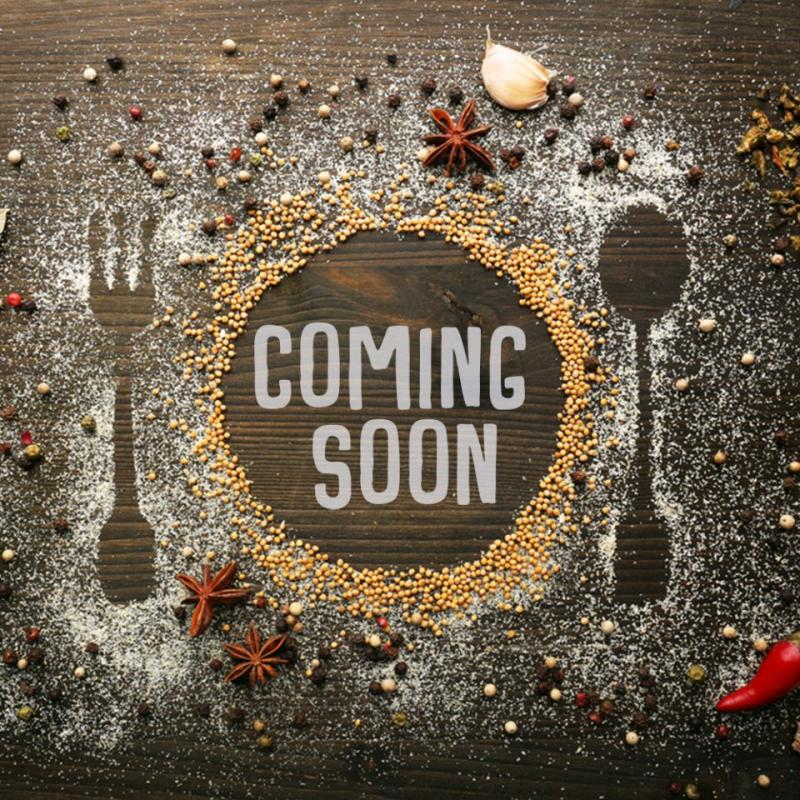

You run a busy new restaurant, and have thousands of reviews on Yelp but no time to read them all. You need a faster way to learn what customers think.

Today, we'll use Large Language Models (LLMs) to extract insights from these reviews to improve your restaurant. We'll explore the power of LLMs for analyzing large volumes of text data.

In this notebook, we'll:

1. Explore and manipulate a real Yelp review dataset.
2. Use word embeddings to find the most relevant reviews.
3. Build a LLM-based system to analyze relevant reviews for key business insights!

Let's get started!

<center> <img src=https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/Taco%20Bell%20Reviews.png> </center>

## Table of Contents

You can find a more detailed Table of Contents by clicking on the icon on the left sidebar that looks like this: <img src="https://drive.google.com/uc?export=view&id=1AGUz4POrRWu_6n5yI_YdO4qFRr41_PzE" width=20>.

>[📊 Milestone 1: Data Exploration](#scrollTo=DQ267zCBOjet)

>>[1.1. Introducing the Data](#scrollTo=GOrurZT1gqgl)

>>[1.2. Analyzing the Text Data through Word Clouds](#scrollTo=iWbBkEnrgvTJ)

>>[1.3. Analyzing Text Data for LLMs](#scrollTo=jOQq4BGglWkK)

>[🏭 Milestone 2: Analyze Reviews with Word Embeddings](#scrollTo=dArbYofKN206)

>>[2.1. Word Embedding Arithmetic](#scrollTo=DwjdwGBktqTW)

>>[2.2. Processing our Input Data](#scrollTo=0bwasn11BfD4)

>[⚖️ Milestone 3: Building an LLM Review Analyst](#scrollTo=EmojdeiNq-PV)

>>[3.1 Combining Semantic Search and an LLM](#scrollTo=7vIEQhys8FnP)

>>[3.2. Experimenting with Models and Parameters](#scrollTo=nNiI3NnT8enp)

>[(Optional) ⚖️ Milestone 4: Exploring Impact and Ethics](#scrollTo=HCpibGeVgy2i)

>[(Optional Challenge) 🧮 Milestone 5: Linear Algebra and Embeddings](#scrollTo=zcqbg3NSNriB)

>[🤔 Knowledge Check](#scrollTo=2e3T609ocyTA)

>[📋 Cheat Sheets](#scrollTo=arJN8ZYjpqFz)

>>[(Optional reference) Functions](#scrollTo=KtK6uG2fHu2n)

>>[(Optional reference) if statements](#scrollTo=yqp-AanZ4v1r)



In [ ]:
#@title **🏗 Setup Cell** {"display-mode":"form", "form-width":"25%"}
#@markdown **Run this to import libraries and download data!**

# =====================
# 📦 Core Libraries
# =====================
import os
import warnings
import locale
import numpy as np
import pandas as pd
import textwrap
from IPython.display import Markdown

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # Suppress warnings
warnings.filterwarnings('ignore')
locale.getpreferredencoding = lambda: "UTF-8"

# =====================
# 🔤 NLP & Text Processing
# =====================
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

import spacy
from wordcloud import WordCloud
import tiktoken

# =====================
# 🤖 Machine Learning Libraries
# =====================

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# =====================
# 🧩 Widgets / Display
# =====================
import ipywidgets as widgets
from IPython.display import display, clear_output

# =====================
# 🔑 OpenAI API
# =====================
from openai import OpenAI

# Get a text response from the OpenAI API
def get_openai_response(prompt, model="gpt-4o-mini", temperature=0.7, max_tokens=200, top_p=1.0):
    """Helper function to get responses from OpenAI with configurable parameters"""
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"Error: {str(e)}"

# Get an embedding vector from the OpenAI API
def get_openai_embedding(text, model="text-embedding-3-small"):
    """Get embeddings from OpenAI API"""
    response = client.embeddings.create(input=text, model=model)
    return np.array(response.data[0].embedding)

# =====================
# 🛠 Utility Functions
# =====================

# Compute cosine similarity between two vectors
def similarity(word1, word2):
    vector1 = word1.reshape(1, -1)
    vector2 = word2.reshape(1, -1)
    return cosine_similarity(vector1, vector2)[0][0]

# Visualize word vectors in 2D space using PCA
def visualize_vectors(words, vectors, labels=None, title="Word Embedding Visualization"):
    vectors_array = np.array(vectors)
    vectors_2d = PCA(n_components=2).fit_transform(vectors_array)

    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'red', 'blue', 'green'][:len(words)]
    sizes = [100, 80, 80, 100, 120][:len(words)]

    for i, (word, color, size) in enumerate(zip(words, colors, sizes)):
        plt.scatter(vectors_2d[i, 0], vectors_2d[i, 1], c=color, s=size, alpha=0.7)
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]),
                     xytext=(10, 10), textcoords='offset points',
                     fontsize=12, fontweight='bold')

    plt.title(title, fontsize=14)
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =====================
# 📂 Data and External Utilities
# =====================
# Inspirit utility file
!wget -q "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Modules/inspiritai_util.py"
from inspiritai_util import handle_discussion_response

# Yelp dataset
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv"


To connect to OpenAI's tools and models via Colab, you'll need an **API key** (linked to an OpenAI account with credits).

If you do not have your own API key, ask your instructor for the **shared API key**. Then, input the key below:

In [ ]:
# @title Insert API key below and run this cell! {"display-mode":"form", "form-width":"25%"}

from openai import OpenAI
import openai

api_key = '' # @param {type:"string"}

client = OpenAI(api_key=api_key)

For more information on how to create an OpenAI account, get an API key, and use it beyond the course, follow our [OpenAI Account and API Key Guide](https://inspiritai.co/GenAIAccountGuide). 📖

### 🔑 (Optional) How to Get Your Own OpenAI API Key

> Check out the next cell to learn how to setup your own OpenAI API key (for your own future use)!


1. **Create an OpenAI account**:
    - Go to [OpenAI's sign up](https://platform.openai.com/signup) page.
   - Create an account or log in.  
   - On the **“Add API credits”** page, purchase **$5 of credits** — enough for this notebook and any exploration beyond class.  
   - *(If you prefer not to buy credits, you can use the class backup key instead.)*

2. **Check your credits:**  
   - Once signed in, visit [Billing](https://platform.openai.com/settings/organization/billing/overview).  
   - If your balance is **\$0.00**, click **“Add payment method”** and make the **minimum $5 initial credit purchase**.

3. **Create your API key:**  
   - Go to OpenAI platform's [API Keys](https://platform.openai.com/api-keys) page.
   - Click **“Create new secret key”** and copy the key (it starts with `sk-...`).
   - Save your API key somewhere safe, to re-use later.

4. **Use your key:**  
   - Paste your API key into the cell below 👇  
   - *(If you don’t have your own key, ask your instructor for the backup class key.)*

---
---
# **📊 Milestone 1: Data Exploration**

## 1.1. Introducing the Data

First, let's start by loading our review data. The data is stored in a file named `yelp_final.csv`. You can see this file for yourself by clicking the folder icon on the left-hand side of the screen. We will use the `read_csv` function from the pandas library to load the data:

In [ ]:
# Load the data
yelp = pd.read_csv('yelp_final.csv')
yelp

### 1.1.1. Discussion Exercise

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *Which column in the dataset represents the user's REVIEW about the restaurant and would be used as the input to our model?*
answer = "" # @param {"type":"string"}


handle_discussion_response(answer)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

1. **Input Variable Identification:** The `'text'` column




### *1.1.2. Coding Exercise*



In the cell below, plot a histogram of the review stars to see how often each appear, using Seaborn's [`sns.histplot()`](https://seaborn.pydata.org/generated/seaborn.histplot.html). Here's the template:

```python
sns.histplot(data=DATAFRAME, x="FEATURE")
```

What does this tell us about customer reviews?



In [ ]:
### WRITE YOUR CODE BELOW



In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}

# Plot histogram of the 'age' column
sns.histplot(data=yelp, x="stars")

#### Instructor Solution  
<details><summary>click to reveal!</summary>


Overall, Yelp reviews show a positive skew, with most ratings being 4 or 5 stars, meaning businesses on Yelp are generally well-reviewed.

This could be for several reasons - satisfied customers review more often, businesses encourage positive feedback, and people are less likely to leave bad reviews unless their experience was very bad.


### (Optional) *1.1.3. Coding Exercise*

> Check out this section if you want to calculate the unique number of businesses in the dataset.



In the cell below, calculate the number of unique businesses in our dataframe. Hint: try using the Pandas [`.nunique()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html) method to count unique values for a given column. Here's the template:

```python
DATAFRAME["FEATURE"].nunique()
```

In [ ]:
### WRITE YOUR CODE BELOW


In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}
yelp['business_id'].nunique()

## 1.2. Analyzing the Text Data through Word Clouds

You want to understand what factors customers care about when they write their reviews. Let's see what people are saying in the reviews.

Do you know what a word cloud is? If not, run the cell below and take a guess.

In [ ]:
#@title {"run":"auto", "display-mode":"form", "form-width":"25%"}
#@markdown Choose a number of stars from the dropdown to display the word cloud for reviews with that rating!

# Set the number of stars to select reviews
num_stars = 1 # @param ["1","2","3","4","5"] {"type":"raw","allow-input":true}

this_star_text = ''
for review in yelp[yelp['stars'] == num_stars]['text'].values:
    this_star_text += review + ' '

wordcloud = WordCloud()
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear');

### 1.2.1. Discussion Exercise

In a word cloud, each word's size corresponds to how often it shows up in reviews. After looking through the word clouds above, answer the following questions!

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. What are the most common words used in the high- and low-rated groups of reviews?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. What are some limitations of using a word cloud as a summary of the reviews?*
answer_2 = "" # @param {"type":"string"}


handle_discussion_response(answer_1, answer_2)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

1. Words like "great," "love," and "favorite" are often used in high-rated reviews while words like "bad," "rude," "disappointing" are often used in low-rated reviews.
2. Many words are commonly used across all the reviews (for example: food, place, good, great, etc.), so those don't really help us differentiate good from bad. Also, word clouds tell us nothing about how these words are used in context (for example, the word cloud for "This is a good place despite the bad reviews" and "This is a bad place despite the good reviews" would be exactly the same)



## 1.3. Analyzing Text Data for LLMs




While word clouds are useful for summarizing text at a glance, we can provide more contextual summarization with help of LLMs! In this next section, we'll examine and prepare our text data so it's ready for analysis with LLMs.

### *1.3.1. Coding Exercise*


When using LLMs, we need to consider how they handle text input. Instead of reading full words, LLMs process **tokens** - small text units (like pieces of words) that combine to form sentences. Each model has a maximum **token limit**, which restricts how much text it can analyze at once.

Ideally, we want our model to summarize and extract insights from all our reviews. However, this might not be possible due to model input limits! To find out, we'll tokenize the reviews and calculate the total number of tokens in the dataset.

In  the code below, we've provided a function `count_tokens()` that takes in text, tokenizes it, and counts the number of tokens.

Below, use the [`.apply()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method to apply `count_tokens` to each review in the Yelp dataset, and store the results in a new column in the `yelp` dataframe (called `token_count`).

Here's the template:

```python
DATAFRAME['FEATURE'].apply(function_name)
```

In [ ]:
# Load the GPT-4o tokenizer from tiktoken (ensuring our tokenizer matches the model we'll use)
encoding = tiktoken.encoding_for_model("gpt-4o")

# Define function to convert text to tokens and count the tokens, using the tokenizer
def count_tokens(text):
    return len(encoding.encode(str(text)))

### YOUR CODE HERE
yelp['token_count'] = # ADD CODE HERE (Hint: Which column in the yelp dataset do we want to .apply() the count_tokens function to?)

# Display the dataframe
yelp.head()

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}

# Load the GPT-4o tokenizer from tiktoken (ensuring our tokenizer matches the model we'll use)
encoding = tiktoken.encoding_for_model("gpt-4o")

# Define function to convert text to tokens and count the tokens, using the tokenizer
def count_tokens(text):
    return len(encoding.encode(str(text)))

# Create new column with review token counts
yelp['token_count'] = yelp['text'].apply(count_tokens)

# Display dataframe
yelp.head()

### *1.3.2. Coding Exercise*



Now that we've calculated the review token counts, let's plot a histogram to see their distribution (hint: as before, try using Seaborn's [`sns.histplot()`](https://seaborn.pydata.org/generated/seaborn.histplot.html) function on the relevant column). What does this reveal about how long most reviews are?

In [ ]:
### YOUR CODE HERE

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}
sns.histplot(data=yelp, x="token_count")

#### Instructor Solution  
<details><summary>click to reveal!</summary>

This histogram shows that most reviews are short - the majority fall under about 200 tokens (~150 words). There's a long tail of longer reviews, but they are much less common, with a few very long reviews but these are outliers.


### *1.3.3. Can we fit all the tokens in the context window?*


So, will our review data fit into a model?

LLMs can only process a fixed number of tokens at a time. These tokens can include your question, earlier messages in a conversation (from you or the LLM), and extra text like our Yelp reviews or other documents. This set of tokens is called the **context window**, the size of which varies from model to model.

Inside the context window, the model compares all the tokens to each other using attention to figure out meaning and relationships. As the number of tokens increases:
- The model has to do more work to compare all the tokens, which uses more resources
- The quality of responses can go down, especially if the window gets too full or crowded

Below is more information on different models from OpenAI, from GPT-3.5 Turbo (one of the models used in the early months of ChatGPT) to more recent models like o3.

<details>
<summary>GPT-3.5-turbo (4k tokens)</summary>

- Lightweight, fast, and cheap. Good for small tasks like chatbots, FAQs, and short text summarization.  
- Fits about ~3,000 words (short story length).  

</details>

<details>
<summary>GPT-3.5-turbo-16k (16k tokens)</summary>

- Still lightweight but with more memory. Good for longer documents, bulk summarization, and batch Q&A.  
- Fits about ~12,000 words (several chapters).  

</details>

<details>
<summary>GPT-4 (8k tokens)</summary>

- Stronger reasoning than 3.5 but slower/more costly. Good for coding help, complex analysis, and nuanced writing.  
- Fits about ~6,000 words (long article).  

</details>

<details>
<summary>GPT-4o (128k tokens)</summary>

- Advanced multimodal model with very large context. Good for analyzing long reports, multiple documents, or even books.  
- Fits about ~100,000 words (a full novel).  

</details>

<details>
<summary>O3 (200k tokens)</summary>

- Cutting-edge reasoning model with massive memory. Good for research-level tasks, comparing large datasets, and deep analysis.  
- Fits about ~150,000 words (a textbook).  

</details>

Below, to check which models can fit our data, calculate the total sum of tokens in the `yelp` reviews, and then run to compare against the OpenAI model limits!  
(For a more in-depth overview of OpenAI models including their specific strengths, check out this [guide](https://zapier.com/blog/openai-models/).)


In [ ]:
### YOUR CODE HERE
num_tokens = # ADD CODE HERE: Calculate the total sum of token counts (Hint: You can use the .sum() method on a Pandas column)

# Define major OpenAI model context limits
context_limits = {
    'gpt-3.5-turbo': 4096,
    'gpt-3.5-turbo-16k': 16384,
    'gpt-4': 8192,
    'o3': 200000,
    'gpt-4o': 128000
}

# For every model let's compare the length of the reviews tokens with the context window limits. If the review text fits in the context window then print '✅ Fits'. Otherwise print '❌ Too long'
print(f"\nTotal tokens in reviews: {num_tokens}\n")
for model, limit in context_limits.items():
    status = '✅ Fits' if num_tokens <= limit else '❌ Too long'
    print(f"{model:<25} Limit: {limit:>6} tokens → {status}")

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}
num_tokens = yelp['token_count'].sum()

# Define major OpenAI model context limits
context_limits = {
    'gpt-3.5-turbo': 4096,
    'gpt-3.5-turbo-16k': 16384,
    'gpt-4': 8192,
    'o3': 200000,
    'gpt-4o': 128000
}

# For every model let's compare the length of the reviews tokens with the context window limits. If the review text fits in the context window then print '✅ Fits'. Otherwise print '❌ Too long'
print(f"\nTotal tokens in reviews: {num_tokens}\n")
for model, limit in context_limits.items():
    status = '✅ Fits' if num_tokens <= limit else '❌ Too long'
    print(f"{model:<25} Limit: {limit:>6} tokens → {status}")

Looks like most models can't fit all of our data at once. And even if they can, giving them too much information at once can cause them to work less well, losing track of earlier inputs - a problem known as ['context rot'](https://research.trychroma.com/context-rot).

Although some models have larger context windows, it is still better to process information in chunks to avoid overloading the model. Like with people, you are likely to get a better response if you present information in more manageable chunks.

### 1.3.4. Discussion Exercise

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. Why can't we just give an LLM all our reviews to analyze directly?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. What are some ideas to process lots of review data to capture insights effectively?*
answer_2 = "" #@param {type:"string"}

handle_discussion_response(answer_1, answer_2)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

1. We can't give all the reviews directly to an LLM (like ChatGPT) because the total number of tokens in the dataset exceeds the model's context window - there's too much text to handle all at once. Even models with very large windows work better when text is split into smaller chunks to avoid memory overload and maintain high-quality analysis.

2. Possible ways to capture insights from lots of reviews include:
    - Pick the most relevant reviews – use a simple search, or (more advanced and efficient) convert reviews to embeddings search semantically to find reviews most related to your question.
    - Summarize in chunks – split reviews into smaller groups, summarize each, then combine the summaries.
    - Cluster reviews by theme – group similar reviews (e.g., about service, food, or price) and analyze each group separately.
    - Run sentiment analysis – classify reviews as positive, negative, or neutral without needing the full text.
    - (If we had location and business data, we could also filter by similar restaurants or restaurants in the same area to get more specific insights.)

---
---
# 🏭 Milestone 2: Analyze Reviews with Word Embeddings

One powerful way to capture insights from more review data than we can fit in a model's context window is by first embedding the reviews and then using math to find the most relevant ones for improving our restaurant.

Let's use word embeddings to get the relevant text for our model's context window!


## 2.1. Word Embedding Arithmetic

Recall that word embeddings encode meaning as numbers. This means that word embeddings which have similar values are likely to mean similar things. Let's explore this!

### Similarity Using Word Vectors


One of the useful things about word embeddings is that we can mathematically calculate how similar they are to one another.

To calculate their similarity, we can use cosine similarity. This calculates the cosine of the *angle* between word vectors - values closer to 1 mean the vectors point in nearly the same direction, while values closer to 0 (or negative) mean they point in different directions:

![](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg)

This is how we will get relevant text for our LLM (by finding the most similar reviews to our desired topic)!

### 2.1.1. Coding Exercise


In the setup cell, we've defined a function called `similarity()` that takes in two word vectors and returns the cosine similarity between them. We'll use this to get the most relevant reviews for our LLM to summarize. (For more on the math of cosine similarity, check out the optional Milestone 5 below on linear algebra and embeddings).

Below, get word embeddings for any 2 words using the `get_openai_embedding()` function, and use the `similarity()` function to explore which words are most and least similar!


In [ ]:
# Get any two word embeddings
vector1 = get_openai_embedding('') # <- Fill in with a word you'd like to compare
vector2 = get_openai_embedding('') # <- Fill in with a word you'd like to compare

# Get similarity score
float(similarity(None, None)) # <- Replace the Nones with the two vectors!

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}

# Get any two word embeddings
vector1 = get_openai_embedding('black')
vector2 = get_openai_embedding('white')

# Get similarity score
float(similarity(vector1, vector2))

### 2.1.2. Discussion Exercise

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. What is a pair of words with a similarity greater than 0.75?*
answer_1 = "" #@param {type:"string"}

#@markdown *2. What is a pair of words with a similarity less than 0.25?*
answer_2 = "" #@param {type:"string"}

#@markdown *3. Try guessing what the similarity score for "black" and "white" is, then compute the similarity. Why might we be getting this score?*
answer_3 = "" #@param {type:"string"}

handle_discussion_response(answer_1, answer_2, answer_3)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

1. 2. Some word pairings with similarity > 0.75:
    - child + kid
    - purchase + buy
    - movie + film
    - end + finish
2. Some word pairings with similarity < 0.25:
    - banana + democracy
    - elephant + software
    - volcano + keyboard
    - quantum + sandwich
3. Word embeddings are created from words appearing in similar *contexts*. Even though we'd consider black and white opposites, they will show up in similar places in sentences very often (and often in the same sentence!)

## 2.2. Processing our Input Data


Now let's shift focus back to our Yelp review dataset. Our overall goal is to choose the most relevant reviews for the topic we care about (like "service quality") so that we can pass just those to the LLM for analysis and suggestions.

To help us do that, we use something called text embeddings. Just like we can turn individual words into vectors (embeddings) that capture their meaning, we can do the same for entire reviews. Here's what that process would look like:

1. First, the review is split into tokens, and each token starts with a basic embedding like the ones we've already explored above.
2. Next, these embeddings go through a transformer model, the same kind we talked about in the lecture. Inside the transformer, each token uses attention to look at the other tokens around it. This helps the model understand the context,  like whether “service” is being praised or criticized. The embeddings' numbers are updated so that they have more information about the context of each word, making it a "context-aware embedding."
3. Finally, these embeddings are combined in some manner (for example, averaging) so that we have one overall embedding for the entire text. We can use those embeddings to compare texts easily!

### 2.2.1. Coding Exercise

Let's embed all our reviews! That way we can easily find and filter the ones which are similar to our query.

In [ ]:
#@title Run to define function to embed text in batches (using an OpenAI embedding model) {"display-mode":"form", "form-width":"25%"}

# Function to embed text in batches
def get_openai_embeddings(texts, model="text-embedding-3-small", batch_size=1000):
    """
    Get embeddings for many texts at once, in batches.

    Parameters:
    - texts: list of strings (the reviews we want to embed)
    - model: which embedding model to use ("text-embedding-3-small" or "text-embedding-3-large")
    - batch_size: how many reviews to send in one request
    """
    all_embeddings = []

    # Go through the reviews in chunks (batches)
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # Select one batch of reviews

        # Ask OpenAI API for embeddings for this batch
        response = client.embeddings.create(
            input=batch,
            model=model
        )

        # Pull out the embedding vectors from the response
        batch_embeddings = [np.array(item.embedding) for item in response.data]

        # Add them to our growing list of all embeddings
        all_embeddings.extend(batch_embeddings)

    # Convert the list into a NumPy array for easier math later
    return np.array(all_embeddings)

Now, let's compute the embeddings for all our reviews, using the `get_openai_embeddings()` function defined in the cell above. Fill in the function below:

In [ ]:
# Convert our reviews to a list
review_texts = yelp['text'].tolist()

### YOUR CODE HERE
# Get embeddings for all reviews (batch size of 1000)
review_embeddings = get_openai_embeddings(None, batch_size=1000) # TO-DO: Replace the "None" with the list of reviews to embed

# Get the shape of the review embeddings
print("\n✅ All embeddings computed and stored!")
print(f"Shape: {review_embeddings.shape}")

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}

# Convert our reviews to a list
review_texts = yelp['text'].tolist()

# Get embeddings for all reviews (batch size of 1000)
review_embeddings = get_openai_embeddings(review_texts, batch_size=1000)

# Get the shape of the review embeddings
print("\n✅ All embeddings computed and stored!")
print(f"Shape: {review_embeddings.shape}")

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *What do these numbers mean? Try matching them to each of the descriptions below, and run the cell to see if you're correct!*

number_of_reviews = None # @param {"type":"integer"}
numbers_per_word_embedding = None # @param {"type":"integer"}

if (number_of_reviews, numbers_per_word_embedding) == (823,1536):
  print(f"Correct!")
else:
  print("Not quite! As a hint, where else may have you seen 823 and 1536 in this notebook?")

#### Instructor Solution  
<details><summary>click to reveal!</summary>

- 823: the number of reviews
- 1536: the number of values (dimensions) in each embedding, representing different features of the review

Great, now go ahead and display a few rows to see what the new embeddings look like!

In [ ]:
# Print 5 review
print(review_embeddings[:5])

### 2.2.2. Coding Exercise

Now let's use our review embeddings to find the reviews most relevant to a search term (the "query"). This lets us filter out the key reviews on a topic so they can fit into our model.

Below, let's make a function to get the most relevant reviews to a query. It should:
- Get the query embedding
- Calculate the similarities between the query embedding and each review embedding
- Return the most similar reviews.

(As a reminder, we can use the `get_openai_embedding()` function to embed a single piece of text.)

In [ ]:
# Let's create your find_top_reviews function
def find_top_reviews(query, review_embeddings, yelp_df, top_n=5):
    """
    Find the most relevant reviews for a given query.
    """
    ### YOUR CODE HERE
    query_embedding = None  # TO-DO: Get query embedding

    # Calculate the similarity between the query embedding and each review embedding
    similarities = []
    for i, review_embedding in enumerate(review_embeddings):
        ### YOUR CODE HERE
        score = similarity(None, None) # TODO: Calculate similarities between the query and current review embedding
        similarities.append((score, i))  # Keep track of each review's index: (similarity score, review index)

    # Sort the list of (score, index) from highest score to lowest
    similarities.sort(reverse=True)

    # Pick the top N results and get the actual review text
    top_results = []
    for score, idx in similarities[:top_n]:
        review_text = yelp_df.iloc[idx]['text']
        top_results.append((score, review_text, idx))

    # Return the list of most relevant reviews
    return top_results

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}
def find_top_reviews(query, review_embeddings, yelp_df, top_n=5):
    """
    Find the most relevant reviews for a given query.
    """
    # Get the embedding for the search query
    query_embedding = get_openai_embedding(query)

    # Calculate the similarity between the query embedding and each review embedding
    similarities = []
    for i, review_embedding in enumerate(review_embeddings):
        score = similarity(query_embedding, review_embedding)
        similarities.append((score, i))  # Keep track of each review's index: (similarity score, review index)

    # Sort the list of (score, index) from highest score to lowest
    similarities.sort(reverse=True)

    # Pick the top N results and get the actual review text
    top_results = []
    for score, idx in similarities[:top_n]:
        review_text = yelp_df.iloc[idx]['text']
        top_results.append((score, review_text, idx))

    # Return the list of most relevant reviews
    return top_results

Now let's test your new function out! Try picking a query (i.e. topic) and number of top reviews below.

Experiment with different queries - do the reviews make sense? Which queries might be most useful for improving a business?

In [ ]:
# Now let's test our function by getting the most relevant reviews!

# First, pick a query (e.g. ""The service was really slow"")
query = input("Enter your search query: ")

# Pick the number of relevant reviews you want
num_reviews = int(input("How many top reviews would you like to see? "))

# Get the most relevant reviews to the query
results = find_top_reviews(query, review_embeddings, yelp, top_n=num_reviews)

# Print the reviews' relevance rank, similarity, and text
for i, (score, review, idx) in enumerate(results):
    print(f"{i+1}. Similarity: {score:.3f}")
    review = textwrap.fill(review, width=80)
    print(f"   Review: {review[:200]}\n")

#### Instructor Solution  
<details><summary>click to reveal!</summary>

Sometimes the reviews are very relevant, but students might observe the filtered reviews sometimes reflect opposite or different meanings, since the embeddings capture similarity but not exact meaning, and might miss negations (e.g. "the food wasn't bad").

Some useful queries for filtering reviews for feedback/improvement include:
- Service issues: `"bad service"`, `"rude staff"`, `"slow service"`, `"long wait times"`
- Positive service: `"friendly staff"`, `"fast service"`
- Food quality: `"undercooked food"`, `"delicious food"`, `"fresh ingredients"`
- Menu & portions: `"portion size"`, `"too expensive"`, `"good value"`, `"favorite dish"`
- Ambiance: `"atmosphere"`, `"loud music"`, `"romantic setting"`, `"cleanliness"`
- Pricing: `"overpriced"`, `"reasonable prices"`
- Customer recommendations: `"recommend trying"`, `"best dish"`, `"would come again"`

Feel free to brainstorm and experiment with different queries!

# ⚖️ Milestone 3: Building an LLM Review Analyst

Great, now that we have a way of getting relevant reviews for any topic (e.g. atmosphere, service, food, value, etc.) with fewer tokens, let's feed these more specific reviews to an LLM to get insights for your restaurant!


## 3.1 Combining Semantic Search and an LLM

For our analysis, we'll run a **semantic search** on the review embeddings. This just means we'll search by meaning (using embeddings) to find the reviews most relevant to a topic, like we did above. Then, we'll pass those selected reviews to the LLM, which will generate business insights from them based on our chosen prompts and parameters.

Let's put these pieces together and practice using LLMs to find and summarize useful insights!





### 3.1.1. Coding Exercise - Putting Together Our LLM System

In this section we'll harness the power of an LLM to analyze our most relevant reviews. We'll do this step-by-step:

1.   Defining a function to get an LLM response
2.   Crafting the system and user prompts
3.   Setting the model parameters
4.   Running the analysis!



#### Step 1. Defining a Function to Get an LLM Response

First, let's create a function to get an LLM's analysis of restaurant reviews using a semantic search to filter for the most relevant reviews.

Complete and define the `get_llm_response()` function, which has the following parameters and output:
- Parameters (inputs): a given topic, the review embeddings, system and user prompts (in other words, instructions, which you'll create soon), the model, and the model's parameters
- Output: the model's response (its analysis of the reviews) based on its prompts and the reviews

The function will:
- Search for the most relevant reviews for a chosen topic
- Format these reviews into text
- Send them to an LLM along with a system and user prompt
- Receive and return the LLM's analysis

To generate the model's response, the function uses OpenAI's [Chat Completions API](https://platform.openai.com/docs/api-reference/chat), which lets you send messages (system + user messages) and receive the chosen model's generated reply.



In [ ]:
def get_llm_response(topic, review_embeddings, yelp_df, system_prompt, user_prompt, model="gpt-4o-mini", temperature=0.7, top_p=1.0, max_tokens=150, top_n=5):
    """
    Get AI analysis of restaurant reviews using semantic search
    """
    ### YOUR CODE BELOW
    # Find the most relevant reviews for the topic, using 'topic' as the search query
    relevant_reviews = # TO-DO: Get the top most relevant reviews (Hint: Use our previously defined function to get the top relevant reviews)

    # Format reviews as simple text
    reviews_list = [review for score, review, idx in relevant_reviews]
    reviews_text = "\n---\n".join(reviews_list)

    # Insert the current topic and reviews into user prompt
    formatted_user_prompt = user_prompt.replace("{topic}", topic).replace("{reviews_text}", reviews_text)

    # Send the response request to OpenAI's API
    try:
        # Set the model's instructions and user prompt
        messages = [
            {"role": "system", "content": None}, # TO-DO: Fill in the system's prompt parameter (replace the None)
            {"role": "user", "content": None} # TO-DO: Fill in the updated user's prompt parameter (replace the None)
        ]
        # Generate the model's response
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )
        # Return the model's response text
        return response.choices[0].message.content.strip()

    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}
def get_llm_response(topic, review_embeddings, yelp_df, system_prompt, user_prompt, model="gpt-4o-mini", temperature=0.7, top_p=1.0, max_tokens=150, top_n=5):
    """
    Get AI analysis of restaurant reviews using semantic search
    """
    # Find the most relevant reviews for the topic, using 'topic' as the search query
    relevant_reviews = find_top_reviews(topic, review_embeddings, yelp_df, top_n=top_n)

    # Format reviews as simple text
    reviews_list = [review for score, review, idx in relevant_reviews]
    reviews_text = "\n---\n".join(reviews_list)

    # Insert the current topic and reviews into user prompt
    formatted_user_prompt = user_prompt.replace("{topic}", topic).replace("{reviews_text}", reviews_text)

    # Send the response request to OpenAI's API
    try:
        # Set the model's instructions and user prompt
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": formatted_user_prompt}
        ]
        # Generate the model's response
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p
        )
        # Return the model's response text
        return response.choices[0].message.content.strip()

    except Exception as e:
        return f"Error: {str(e)}"

#### Step 2. Crafting the System and User Prompts

Now let's create our model instructions using prompt engineering. Prompt engineering is a powerful way to guide an LLM's behavior without changing its internal parameters. By instructing the model on how to behave, you can have it perform different tasks with specific styles, tones, and output formats.

We'll create two types of input prompts:

- **System prompt** - Defines how the model should behave (like its task, role, and output style)
- **User prompt** - Sets the user's question or instructions for the model to respond to

Strong system prompts have three key parts:
- Task - What should the model do?
- Role - Who should it be?
- Output - How should the model format its reply?

What task, role, and output format would be most useful for this task? We've provided examples, but go ahead and draft your own system and user prompts below! (Get creative, you can always test and edit these.)

In [ ]:
# Create your system prompt
SYSTEM_PROMPT = "You are an expert restaurant consultant analyzing customer reviews." # TO-DO: Write your own system prompt (Hint: Add it's specific task, role, and output format)

# Create your user prompt, always using {reviews_text} as a placeholder for the reviews!
# TO-DO: Write your own user prompt
USER_PROMPT = """Analyze these reviews:

{reviews_text}

Based on the reviews, provide actionable tips for restaurant owners."""

#### Step 3. Setting Model Parameters

Next, let's experiment with different model parameters to see how they affect its responses. These parameters - essentially the model's settings - control how it thinks and responds, letting us fine-tune how it works.

In short, the prompt tells the model what to do, while the parameters shape how it does it.

Here's what each parameter does:

* `MODEL` - Choose which LLM to use (e.g. `gpt-4o-mini` for balance, or `gpt-4.1-nano` for speed on lightweight tasks).

* `TEMPERATURE` - Controls word prediction randomness/creativity:
  - 0 = very focused/consistent
  - higher values (~1.4) = more random/creative.

* `TOP_P` - Limits the vocabulary the model can choose from:
  - 0.1 = very focused
  - 1.0 = more diverse

* `MAX_TOKENS` - Maximum number of tokens (words/chunks) in the model's response.

* `TOP_N` - Number of most relevant reviews to include as context for the LLM.

Try changing these values and see how the model's analysis of reviews changes!

In [ ]:
# Configure your own model parameters - you can experiment with these soon!
MODEL = "gpt-4o-mini" # Example: "gpt-4o-mini" (balanced) or "gpt-4.1-nano" (fast/lightweight)
TEMPERATURE = 0.5     # Between 0 (focused/consistent) and ~1.4 (creative/random)
TOP_P = 0.5           # 0.1 = focused vocabulary, 1.0 = diverse vocabulary
MAX_TOKENS = 200      # Maximum length of LLM response
TOP_N = 50            # Number of reviews to pass into the LLM for context

#### Step 4. Running the Analysis

  Now let's put everything together to analyze the reviews! You've created your function to get the LLM response, wrote your system and user prompts, and set your model parameters.

  Below, set your topic and run the `get_llm_response()` function with your current parameters to analyze your reviews. You can try different topics, prompts, and parameters (more experimenting in the next section)!

In [ ]:
# Set your topic/query (e.g. "service quality", "food quality", "atmosphere", "value for money", "cleanliness")
TOPIC = "" # TO-DO: Set your topic

# Run analysis
analysis = get_llm_response(TOPIC, review_embeddings, yelp, SYSTEM_PROMPT, USER_PROMPT,
                         model=MODEL, temperature=TEMPERATURE, top_p=TOP_P, max_tokens=MAX_TOKENS, top_n=TOP_N)

# Get the relevant reviews to display separately
relevant_reviews = find_top_reviews(TOPIC, review_embeddings, yelp, top_n=TOP_N)
reviews_list = [review for score, review, idx in relevant_reviews]

# Print the relevant reviews, topic, and model response
print(f"Relevant Reviews: {reviews_list[0:5]}...")  # First 5 reviews
print(f"Topic: {TOPIC}")
display(Markdown(f"Analysis:\n{analysis}"))

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}
TOPIC = "service quality"

# Run analysis
analysis = get_llm_response(TOPIC, review_embeddings, yelp, SYSTEM_PROMPT, USER_PROMPT,
                         model=MODEL, temperature=TEMPERATURE, top_p=TOP_P, max_tokens=MAX_TOKENS, top_n=TOP_N)

# Get the relevant reviews to display separately
relevant_reviews = find_top_reviews(TOPIC, review_embeddings, yelp, top_n=TOP_N)
reviews_list = [review for score, review, idx in relevant_reviews]

# Print the relevant reviews, topic, and model response
print(f"Relevant Reviews: {reviews_list[0:5]}...")  # First 5 reviews
print(f"Topic: {TOPIC}")
display(Markdown(f"Analysis:\n{analysis}"))

## 3.2. Experimenting with Models and Parameters

Great work! Now that you have the steps set up, let's experiment and compare different models and their inputs and parameters to find which work best for our task!

### 3.2.1. LLM Evaluation Dashboard

There are *many* possible models and parameters to choose from. A good way to find the best ones is to compare the outputs side-by-side. We've created an LLM evaluation dashboard to do this.

Use the dashboard below to choose a model, topic, parameters, and the best prompts!

In [ ]:
#@title 🏗 Run cell to load dashboard functions {"display-mode":"form", "form-width":"25%"}
# helpter functions for transformers section

# ==============================
#  📊 Dashboard helper functions
# ==============================

# Create UI controls and output area for one summary experiment
def create_summary_controls_with_output(summary_name, summary_num, default_model='gpt-4o-mini', default_temp=0.7, default_top_p=0.8, default_tokens=150):
    """Create a complete summary box with controls and output area (uses student's predefined prompts)"""

    # Model selection dropdown
    model_widget = widgets.Dropdown(
        options=[
            ('GPT-4o Mini', 'gpt-4o-mini'),
            ('GPT-4.1 Nano', 'gpt-4.1-nano'),
            ('GPT-4 Turbo', 'gpt-4-turbo')
        ],
        value=default_model,
        description='Model:',
        style={'description_width': '55px'},
        layout=widgets.Layout(width='200px')
    )

    # Temperature slider
    temp_widget = widgets.FloatSlider(
        value=default_temp,
        min=0.1,
        max=1.5,
        step=0.1,
        description='Temp:',
        readout_format='.1f',
        style={'description_width': '55px'},
        layout=widgets.Layout(width='200px')
    )

    # Top P slider
    top_p_widget = widgets.FloatSlider(
        value=default_top_p,
        min=0.3,
        max=1.0,
        step=0.1,
        description='Top P:',
        readout_format='.1f',
        style={'description_width': '55px'},
        layout=widgets.Layout(width='200px')
    )

    # Max tokens slider
    tokens_widget = widgets.IntSlider(
        value=default_tokens,
        min=50,
        max=300,
        step=25,
        description='Tokens:',
        style={'description_width': '55px'},
        layout=widgets.Layout(width='200px')
    )

    # Provide a default system and user prompt if they aren't defined
    try:
        SYSTEM_PROMPT = SYSTEM_PROMPT
    except NameError:
        SYSTEM_PROMPT = "You are an AI assistant that analyzes restaurant reviews and extracts useful insights."

    try:
        USER_PROMPT = USER_PROMPT
    except NameError:
        USER_PROMPT = """
        Analyze these reviews focusing on {topic}:
        {reviews_text}
        Provide 3 actionable tips for restaurant owners."""

    # System prompt - uses student's predefined SYSTEM_PROMPT
    system_prompt_widget = widgets.Textarea(
        value=SYSTEM_PROMPT,
        placeholder="Leave empty to use default from get_ai_response function",
        description='System:',
        style={'description_width': '55px'},
        layout=widgets.Layout(width='380px', height='60px')
    )

    # User prompt - uses student's predefined USER_PROMPT
    user_prompt_widget = widgets.Textarea(
        value=USER_PROMPT,
        placeholder="Leave empty to use default from get_ai_response function",
        description='User:',
        style={'description_width': '55px'},
        layout=widgets.Layout(width='380px', height='80px')
    )

    # Run button
    run_button = widgets.Button(
        description=f'Run Exp {summary_num}',
        button_style='primary',
        layout=widgets.Layout(width='160px', height='32px')
    )

    # Individual output area for this summary
    output_area = widgets.Output(layout=widgets.Layout(
        border='1px solid #ddd',
        padding='8px',
        margin='5px 0',
        min_height='180px',
        max_height='350px',
        overflow='auto'
    ))

    # Initialize with placeholder text
    with output_area:
        print(f"Click 'Run Exp {summary_num}' above to generate analysis...")

    return model_widget, temp_widget, top_p_widget, tokens_widget, system_prompt_widget, user_prompt_widget, run_button, output_area

# Get reviews for a topic (semantic search if embeddings available, else fallback to first N)
def get_reviews_for_topic(topic, num_reviews):
    """Helper function to get relevant reviews for any topic"""
    query = topic.strip().lower() # Convert to lowercase and remove trailing whitespace

    try:
        # Use semantic search if embeddings are available
        if 'review_embeddings' in globals() and review_embeddings is not None:
            top_results = find_top_reviews(query, review_embeddings, yelp, top_n=num_reviews)
            return [result[1] for result in top_results]

    except Exception as e:
        print(f"⚠️ Error in semantic search: {e}")

    # Fallback: just take first N reviews
    return yelp['text'].head(num_reviews).tolist()

# Call OpenAI model (supports o3-mini via responses API, else standard chat completions)
def call_openai_model(model, messages, temperature, top_p, max_tokens):
    """Helper function to call different OpenAI models with unified interface"""

    if model == 'o3-mini':
        # O3 Mini uses the new responses API (temperature/top_p not supported)
        try:
            # Convert messages to O3 format
            o3_input = []
            for msg in messages:
                if msg["role"] == "system":
                    # Add system message as user message with special formatting
                    o3_input.append({
                        "role": "user",
                        "content": [{"type": "input_text", "text": f"System: {msg['content']}"}]
                    })
                elif msg["role"] == "user":
                    o3_input.append({
                        "role": "user",
                        "content": [{"type": "input_text", "text": msg["content"]}]
                    })

            response = client.responses.create(
                model="o3-mini",
                input=o3_input,
                text={"format": {"type": "text"}},
                reasoning={"effort": "medium"},
                tools=[],
                store=True
            )

            # Extract text from O3 response - correct format
            if hasattr(response, 'output') and response.output:
                for output_item in response.output:
                    if output_item.get('type') == 'message' and output_item.get('role') == 'assistant':
                        content = output_item.get('content', [])
                        for content_item in content:
                            if content_item.get('type') == 'output_text':
                                return content_item.get('text', 'No text found')

            return "No response generated from O3"

        except Exception as e:
            return f"O3 Model Error: {str(e)}"

    else:
        # Standard chat completions for other models
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature,
                top_p=top_p
            )
            return response.choices[0].message.content.strip()

        except Exception as e:
            return f"Model Error: {str(e)}"

# Run a single analysis (gathers reviews, formats prompts, queries model, returns summary)
def run_single_analysis(model, temperature, top_p, max_tokens, system_prompt, user_prompt, topic, num_reviews):
    """Run analysis for a single summary - calls the student's function with proper model handling"""

    # Get reviews for the topic
    reviews_sample = get_reviews_for_topic(topic, num_reviews)
    reviews_text = "\n".join([f"• {review}" for review in reviews_sample])

    if len(reviews_text.strip()) == 0:
        return {'success': False, 'error': "No reviews found!"}

    try:
        # Use individual prompts if provided, otherwise use defaults
        system_prompt_to_use = system_prompt.strip() if system_prompt.strip() else "You are an expert restaurant consultant analyzing customer reviews."
        user_prompt_to_use = user_prompt.strip() if user_prompt.strip() else """Analyze these reviews focusing on {topic}:

    {reviews_text}

    Provide 3 actionable tips for restaurant owners."""

        # Format the user prompt
        formatted_user_prompt = user_prompt_to_use.replace("{topic}", topic).replace("{reviews_text}", reviews_text)

        # Create messages
        messages = [
            {"role": "system", "content": system_prompt_to_use},
            {"role": "user", "content": formatted_user_prompt}
        ]

        # Call the appropriate model
        result = call_openai_model(model, messages, temperature, top_p, max_tokens)

        return {
            'success': True,
            'summary': result,
            'topic': topic,
            'num_reviews': len(reviews_sample)
        }

    except Exception as e:
        return {'success': False, 'error': str(e)}

# Display the model’s output in its designated widget area
def display_result_in_output(result, output_widget, summary_num):
    """Display result in the specific output widget"""
    with output_widget:
        clear_output()
        if result['success']:
            summary_text = result['summary']
            if summary_text and summary_text.strip():
                print(f"Topic: {result['topic'].replace('_', ' ').title()}")
                print(f"Reviews analyzed: {result['num_reviews']}")
                print("-" * 40)
                display(Markdown(summary_text))
            else:
                print("Model returned empty response. Try adjusting parameters or running again.")
        else:
            print(f"Error: {result['error']}")
            print("Please check your settings or try again.")

# Update preview of reviews shown in the dashboard
def update_reviews_preview(reviews_expander, topic, num_reviews):
    """Update the reviews preview when topic or number changes"""

    # Get reviews for preview
    selected_reviews = get_reviews_for_topic(topic, num_reviews)

    # Determine preview text based on whether we used semantic search
    if 'review_embeddings' in globals():
        preview_text = f"📍 Showing {len(selected_reviews)} most relevant reviews for '{topic.title()}':\n\n"
    else:
        preview_text = f"📍 Showing first {len(selected_reviews)} reviews:\n\n"

    # Format preview (show max 10 for readability)
    for i, review in enumerate(selected_reviews[:10]):
        preview_text += f"{i+1}. {review[:100]}...\n\n"

    if len(selected_reviews) > 10:
        preview_text += f"... and {len(selected_reviews) - 10} more reviews"

    with reviews_expander.children[0]:
        reviews_expander.children[0].clear_output()
        print(preview_text)

# Build the full interactive dashboard (topic input, controls, review preview, 2 experiments)
def setup_dashboard():
    """Set up the complete LLM Evaluation dashboard interface with topic-based analysis"""

    # Replace dropdown with free-text input for topic
    global_topic = widgets.Text(
        value='Food quality',
        description='Analysis Topic:',
        placeholder='Enter any topic (e.g., service, cleanliness, drinks)',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='300px')
    )

    # Global controls (shared across all experiments)
    global_num_reviews = widgets.Dropdown(
        options=[
            ('10 reviews', 10),
            ('25 reviews', 25),
            ('50 reviews', 50),
            ('100 reviews', 100),
            ('200 reviews', 200)
        ],
        value=50,
        description='Context Size:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='250px')
    )

    # Reviews preview expander
    reviews_expander = widgets.Accordion([widgets.Output()], titles=['View Selected Reviews'])
    reviews_expander.selected_index = None  # Start collapsed

    def on_topic_change(change=None):
        """Update preview when topic or number changes"""
        topic = global_topic.value.strip() or "food quality"
        num_reviews = global_num_reviews.value if hasattr(global_num_reviews, 'value') else 50
        update_reviews_preview(reviews_expander, topic, num_reviews)

    # Update preview when inputs change
    global_topic.observe(on_topic_change, names='value')
    global_num_reviews.observe(on_topic_change, names='value')

    # Initialize preview
    on_topic_change()

    # Create controls and outputs for TWO summaries - both default to gpt-4o-mini
    summary1_widgets = create_summary_controls_with_output("Summary 1", 1, 'gpt-4o-mini', 0.1, 0.3, 150)
    summary2_widgets = create_summary_controls_with_output("Summary 2", 2, 'gpt-4o-mini', 1.4, 1.0, 150)

    # Unpack widgets for easier access
    (model1, temp1, top_p1, tokens1, sys_prompt1, user_prompt1, button1, output1) = summary1_widgets
    (model2, temp2, top_p2, tokens2, sys_prompt2, user_prompt2, button2, output2) = summary2_widgets

    # Create click handlers for each button
    def on_button1_click(button):
        with output1:
            clear_output()
            print("Analyzing reviews... Please wait...")
        result = run_single_analysis(
            model1.value, temp1.value, top_p1.value, tokens1.value,
            sys_prompt1.value, user_prompt1.value,
            global_topic.value, global_num_reviews.value
        )
        display_result_in_output(result, output1, 1)

    def on_button2_click(button):
        with output2:
            clear_output()
            print("Analyzing reviews... Please wait...")
        result = run_single_analysis(
            model2.value, temp2.value, top_p2.value, tokens2.value,
            sys_prompt2.value, user_prompt2.value,
            global_topic.value, global_num_reviews.value
        )
        display_result_in_output(result, output2, 2)

    # Connect buttons to handlers
    button1.on_click(on_button1_click)
    button2.on_click(on_button2_click)

    # Utility buttons
    clear_all_button = widgets.Button(
        description='Clear All Results',
        button_style='warning',
        layout=widgets.Layout(width='150px', height='35px')
    )

    run_all_button = widgets.Button(
        description='Run Both Experiments',
        button_style='success',
        layout=widgets.Layout(width='170px', height='35px')
    )

    def clear_all_outputs(button):
        """Clear all output areas"""
        for output_widget, num in [(output1, 1), (output2, 2)]:
            with output_widget:
                clear_output()
                print(f"Click 'Run Exp {num}' above to generate analysis...")

    def run_all_experiments(button):
        """Run both experiments sequentially"""
        # Show loading messages
        for output_widget, num in [(output1, 1), (output2, 2)]:
            with output_widget:
                clear_output()
                print(f"Running Experiment {num}... Please wait...")

        # Run experiment 1
        result1 = run_single_analysis(
            model1.value, temp1.value, top_p1.value, tokens1.value,
            sys_prompt1.value, user_prompt1.value,
            global_topic.value, global_num_reviews.value
        )
        display_result_in_output(result1, output1, 1)

        # Run experiment 2
        result2 = run_single_analysis(
            model2.value, temp2.value, top_p2.value, tokens2.value,
            sys_prompt2.value, user_prompt2.value,
            global_topic.value, global_num_reviews.value
        )
        display_result_in_output(result2, output2, 2)

    clear_all_button.on_click(clear_all_outputs)
    run_all_button.on_click(run_all_experiments)

    # Create the dashboard layout
    help_text = widgets.HTML(value="""
    <div style='background-color: #e8f4fd; padding: 15px; border-radius: 10px; margin-bottom: 20px;'>
    <h3>🤖 LLM Evaluation Dashboard</h3>
    <p><strong>Goal:</strong> Compare how different LLM parameters affect AI responses using restaurant review analysis!</p>

    <div style='display: flex; gap: 30px; margin-top: 15px;'>
    <div>
    <p><strong>Model Guide:</strong></p>
    <ul style='margin: 5px 0; font-size: 14px;'>
    <li><strong>GPT-4o Mini:</strong> Fast and efficient</li>
    <li><strong>GPT-4.1 Nano:</strong> Newest, more costly compact model</li>
    <li><strong>GPT-4 Turbo:</strong> Balanced, in between GPT-4o Mini and GPT-4.1 Nano for cost and speed.  </li>
    </ul>
    </div>
    <div>
    <p><strong>Parameter Guide:</strong></p>
    <ul style='margin: 5px 0; font-size: 14px;'>
    <li><strong>Temperature:</strong> 0.1=predictable, 1.4=creative</li>
    <li><strong>Top P:</strong> 0.3=focused, 1.0=diverse</li>
    <li><strong>Tokens:</strong> Response length (50-300)</li>
    </ul>
    </div>
    </div>

    <p><strong>💡 Tip:</strong> Compare different temperatures and models to see response variations!</p>
    </div>
    """)

    # Global controls section
    global_controls = widgets.VBox([
        widgets.HTML(value="<h4 style='color: #333; margin: 10px 0;'>📊 Analysis Settings (Applied to All Experiments)</h4>"),
        widgets.HBox([global_topic, global_num_reviews], layout=widgets.Layout(margin='5px 0')),
        reviews_expander
    ], layout=widgets.Layout(border='2px solid #ddd', padding='15px', margin='10px 0', border_radius='10px', background_color='#f9f9f9'))

    # Create the TWO summary columns
    summary1_column = widgets.VBox([
        widgets.HTML(value="<h4 style='text-align: center; color: #1f77b4; margin: 5px 0;'>EXPERIMENT 1</h4>"),
        model1, temp1, top_p1, tokens1,
        widgets.HTML(value="<h5 style='margin: 8px 0 3px 0; color: #1f77b4; font-size: 12px;'>Prompts (uses your defaults):</h5>"),
        sys_prompt1, user_prompt1,
        widgets.HTML(value="<div style='margin: 8px 0;'></div>"),
        button1,
        widgets.HTML(value="<h5 style='margin: 10px 0 5px 0; color: #1f77b4; font-size: 14px;'>Response:</h5>"),
        output1
    ], layout=widgets.Layout(border='2px solid #1f77b4', padding='10px', margin='3px', border_radius='8px', width='400px'))

    summary2_column = widgets.VBox([
        widgets.HTML(value="<h4 style='text-align: center; color: #ff7f0e; margin: 5px 0;'>EXPERIMENT 2</h4>"),
        model2, temp2, top_p2, tokens2,
        widgets.HTML(value="<h5 style='margin: 8px 0 3px 0; color: #ff7f0e; font-size: 12px;'>Prompts (uses your defaults):</h5>"),
        sys_prompt2, user_prompt2,
        widgets.HTML(value="<div style='margin: 8px 0;'></div>"),
        button2,
        widgets.HTML(value="<h5 style='margin: 10px 0 5px 0; color: #ff7f0e; font-size: 14px;'>Response:</h5>"),
        output2
    ], layout=widgets.Layout(border='2px solid #ff7f0e', padding='10px', margin='3px', border_radius='8px', width='400px'))

    # Complete dashboard
    utility_buttons_row = widgets.HBox([
        run_all_button,
        widgets.HTML(value="<span style='margin: 0 15px; color: #666;'>|</span>"),
        clear_all_button,
        widgets.HTML(value="<span style='margin-left: 20px; color: #666;'>Compare models and parameters side-by-side!</span>")
    ], layout=widgets.Layout(margin='10px 0'))

    columns_row = widgets.HBox([summary1_column, summary2_column])

    dashboard = widgets.VBox([help_text, global_controls, utility_buttons_row, columns_row])

    return dashboard

In [ ]:
# Display the dashboard
display(setup_dashboard())

Once you've explored different models, prompts, and parameters, answer the following questions and discuss your findings with the group:

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. Why is it useful to compare models and parameters?*
answer_1 = "" #@param {type:"string"}

#@markdown *2. What model will you choose, and why?*
answer_2 = "" #@param {type:"string"}

#@markdown *3. What prompts will you use, and why?*
answer_3 = "" #@param {type:"string"}

#@markdown *4. What temperature and top P will you use, and why?*
answer_4 = "" #@param {type:"string"}

#@markdown *5. Are LLMs better for summarisation or recommendations? What are the pros and cons of using AI for these tasks?*
answer_5 = "" #@param {type:"string"}


handle_discussion_response(answer_1, answer_2, answer_3, answer_4, answer_5)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

1. Comparing models and parameters helps us see how different settings affect speed, accuracy, and creativity so we can choose the best setup for analyzing restaurant reviews effectively.

2. Choosing a model depends on the task — smaller models are faster and cheaper for quick overviews, while larger ones are better for deeper insights, such as detecting themes or customer sentiment. A balanced model like gpt-4o-mini is a good choice here because it offers strong performance and reasonable speed.

3. Clear, specific prompts work best, such as asking the model to “summarize common complaints about service” or “identify trends in food quality comments,” since focused instructions lead to more useful insights.

4. Moderate temperature and top_p values usually give a good balance between creativity and consistency. Lower values are better for factual summaries, while slightly higher ones can help generate new ideas for improving the restaurant experience.

5. LLMs are helpful for both summarizing and generating recommendations from customer reviews, but they can miss nuance or context. Pros include saving time by analyzing large volumes of feedback, spotting hidden patterns, and providing quick insights for decision-making. Cons include possible bias, lack of real-world understanding, and missing subtle context (like sarcasm or cultural tone). They work best when used to assist human reviewers, giving a strong starting point for analysis that people can then refine and validate with thier own judgment.

## (Optional) Transformer Step-by-Step Explainer

> Check out this section for a more advanced, in-depth visualization of how transformers work step-by-step!

To check out how transformers work step-by-step, from input text to output generation, check out this [transformer explainer](https://poloclub.github.io/transformer-explainer/) visualization as a group!

Try inputting an example review, such as "*The food was amazing, but the service was slow."*

As you explore, consider:
- How does the model understand the meaning of each word in a review?
- How does the model keep track of the words' meaning, order, and relationships?
- How does attention help it focus on the most important parts of a review?
-How does the model's understanding change as the text moves through each layer?



---
---
# (Optional) ⚖️ Milestone 4: Exploring Impact and Ethics



Whenever we explore a new potential use of AI, it is crucial to have a discussion about the **societal and ethical impact** if it were to be implemented at a large scale.

<center> <img src="https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/AI%20Ethics.png"> </center>

### 📈 Who might this AI impact?

An important part of incorporating AI into your business is understanding how it might impact the people involved.
Let's come up with 3 groups of people that would be impacted by an AI that can analyze reviews for business insights. We will call these groups `stakeholders`.



In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
stakeholder1 = '' #@param {type:"string"}
stakeholder2 = '' #@param {type:"string"}
stakeholder3 = '' #@param {type:"string"}

handle_discussion_response(stakeholder1, stakeholder2, stakeholder3)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

Three key stakeholders include:
- Business owners/managers
- Employees/staff
- Customers




**Discuss**: For each of those stakeholders, what are some benefits of this use of AI? What are some possible drawbacks?








In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
answer = '' #@param {type:"string"}

handle_discussion_response(answer)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

The possible benefits and drawbacks of using LLMs to analyze reviews for the different stakeholders include:

- Business owners/managers:  
  - Benefits: help identify strengths/weaknesses quickly, make data-driven decisions, save time  
  - Drawbacks: might misinterpret customer needs and miss nuance and emotional context, the LLM might not prioritize reviews and feedback adequately or sufficiently understand the business' context, risk of over-relying on AI, possible errors/hallucinations

- Employees/staff:  
  - Benefits: can provide clear feedback on performance, targeted training, recognition of positives  
  - Drawbacks: staff might feel undervalued if their feedback isn't listened to, the LLM feedback may feel harsh without context, and it might add stress if applied rigidly  

- Customers:  
  - Benefits: feedback acted on faster, improved products/services, feel more valued  
  - Drawbacks: may feel unheard if the LLM oversimplified or misinterpreted their feedback, unique needs may be overlooked, possible privacy concerns  




**Discuss**: What are some potential sources of bias?

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
answer = '' #@param {type:"string"}

handle_discussion_response(answer)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

Potential sources of bias here include:

- Sampling bias: Reviews may not represent all customers (e.g., mostly extreme opinions, or only certain groups tend to leave reviews).  
- Model bias: The AI model is trained on internet text, which may include cultural or societal biases.  
- Interpretation bias: The AI might overemphasize certain words or miss subtle context in reviews.  
- Business/human bias: Managers may rely on AI outputs that confirm their own assumptions.



**Discuss**: What are some other related ethical questions or scenarios?

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
answer = '' #@param {type:"string"}

handle_discussion_response(answer)

#### Instructor Solution  
<details><summary>click to reveal!</summary>

Related ethical questions for this use of LLMs include (but aren't limited to):

- How much trust should managers place in AI vs. their own or their staff's judgment?  
- Should businesses disclose when reviews are analyzed by AI?  
- If reviews suggest a change that improves profits but worsens working conditions for staff, should it be implemented?
- Who is responsible if AI misinterprets reviews and harms decision-making?
- Is it ethical to process and store reviews without customer consent?  
- Could AI give more weight to some customer voices than others?  
- Will customers feel heard if reviews are summarized by AI instead of read by people?  
- Could using AI reduce the need for certain employee roles?  

---
---
# (Optional Challenge) 🧮 Milestone 5: Linear Algebra and Embeddings

> (Heads-up: this challenge section is math-heavy!)

One reason text embeddings are cool is that we can use them to explore connections in meaning between different words, including calculating similarity between words and completing [analogies](http://epsilon-it.utu.fi/wv_demo/).

To get started, we'll first create a vocabulary of the most common words from our Yelp reviews dataset. We'll use a technique called the Bag of Words (BOW) model with a Counter Vectorizer, which counts how often each word appears. From this, we'll select the top 500 most frequently used words to form our vocabulary.

Next, we'll create a dictionary containing the vectors for all the words in our vocabulary. This dictionary will help us analyze the relationships between words. If you want to use more than 500 words, feel free to change that number!

In [ ]:
#@title Run this to define our vocabulary builder! {"display-mode":"form", "form-width":"25%"}
nltk.download('stopwords')
nltk.download('punkt_tab')
!python -m spacy download en_core_web_lg -q

import en_core_web_lg
text_to_nlp = en_core_web_lg.load()

from nltk.corpus import stopwords
from collections import Counter

# Convert a word into its vector representation using SpaCy
def word2vec(word):
    return text_to_nlp(word).vector

def build_vocab_dict(texts, top_n=500):
    """
    Builds a dictionary of the most common words and their embeddings using SpaCy.

    Args:
        texts (list of str): The list of texts from which to build the vocabulary.
        top_n (int): The number of top words to include in the vocabulary.

    Returns:
        dict: A dictionary mapping words to their embeddings.
    """
    # Tokenize the text and lower case each word
    tokens = [word.lower() for text in texts for word in word_tokenize(text)]

    # Remove stopwords and non-alphabetic tokens
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]

    # Count the occurrences of each word
    word_counts = Counter(filtered_tokens)

    # Select the top 'top_n' most common words
    most_common_words = [word for word, count in word_counts.most_common(top_n)]

    # Create a dictionary for the most common words and their embeddings
    vocab_dict = {}
    for word in most_common_words:
        token = text_to_nlp.vocab[word]
        if token.has_vector:  # Check if the token has a vector in the model's vocabulary
            vocab_dict[word] = token.vector
        else:
            # Handle out-of-vocabulary words by assigning a zero vector
            embedding_dim = text_to_nlp.vocab.vectors_length
            vocab_dict[word] = np.zeros((embedding_dim,))

    return vocab_dict

# Example usage:
# X_text_example = ["This is the first document.", "This document is the second document.", "And this is the third one."]
# vocab_dict = build_vocab_dict(X_text_example)
# print(vocab_dict)


In [ ]:
vocab_dict = build_vocab_dict(yelp['text'], top_n = 800)

for word, vec in vocab_dict.items():
  print(word)

print ('{} words in our dictionary'.format(len(vocab_dict)))

### Cosine Similarity
Next, let's calculate the similarity between two words, using their Word2Vec representations. As before, we'll use cosine similarity to measure the similarity between our vectors.

As an example, imagine we had two three-dimensional vectors:

In [ ]:
v0 = [2,3,1]
v1 = [2,4,1]

Run the code below to plot those vectors, and try changing the numbers above.
How can you make a very small angle between the vectors? How can you make a very large angle?

In [ ]:
#@title Run this to create an interactive 3D plot {"display-mode":"form", "form-width":"25%"}
#NOTE: Would be extra cool with sliders for the vector coordinates! - DREW
#Code from https://stackoverflow.com/questions/47319238/python-plot-3d-vectors
import numpy as np
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()


vector_plot([v0,v1])

### 📐 Cosine Similarity Formula

Cosine similarity measures the cosine of the angle between two non-zero vectors. This is used to assess how close two items are. It ranges from -1 (exactly opposite) to 1 (exactly the same), with 0 typically indicating no similarity.
The cosine similarity between two vectors $ \mathbf{A} $ and $ \mathbf{B} $ is calculated as follows:

$$ \text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{ \|\mathbf{A}\| \|\mathbf{B}\|} $$

Where:
- $ \mathbf{A} \cdot \mathbf{B} $ is the dot product of the vectors,
- $ \|\mathbf{A}\| $ and $ \|\mathbf{B}\| $ are the norms (or magnitudes) of the vectors. Really, this is just another fancy way of saying "length".

To successfully implement this, here are some helpful hints regarding the functions and libraries you might need:



#### Functions and Methods to Use:
1. **`np.dot()` or `@` operator:** Use this to compute the dot product of two vectors. This function takes two arrays and returns their dot product.
   
   ```python
   dot_product = np.dot(vector1, vector2)
   # or
   dot_product = vector1 @ vector2
   ```

2. **`np.linalg.norm()`:** This function computes the norm (magnitude) of a vector. You'll need to calculate the norm for both vectors involved in the cosine similarity.

   ```python
   norm_vector = np.linalg.norm(vector1)
   ```
   
Use these functions to calculate the cosine similarity according to the formula:

$$ \text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} $$

In [ ]:
# WRITE YOUR CODE BELOW: Replace the Nones. Assume the vectors are numpy arrays already!
def my_cosine_similarity(vec1, vec2):
    dot_product = None
    norm_vec1 = None
    norm_vec2 = None
    similarity = None
    return similarity


In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}

def my_cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm_vec1 * norm_vec2)
    return similarity

In [ ]:
#@title Run this to check if your function is correct! {"display-mode":"form", "form-width":"25%"}

# Example vectors
vector1 = np.array([1, 2, 3])
vector2 = np.array([1, 5, 7])

# Compute the cosine similarity
similarity_score = my_cosine_similarity(vector1, vector2)
print("Cosine Similarity:", similarity_score)
print("Correct answer: 0.9875414397573881")

## Exercise: Identifying Similar Words Using Your Cosine Similarity Function

In this exercise, you will apply your own implementation of cosine similarity to find the most similar word to a given target word in a vocabulary. You’ll be using the `my_cosine_similarity` function that you wrote earlier, leveraging it to compare word vectors and identify the closest matches.

### What You'll Do

Write a function named `find_most_similar` that utilizes your `my_cosine_similarity` function to determine which word in a predefined vocabulary is most similar to a specified target word. The function should return both the most similar word and its similarity score!

### Some Guidelines

1. **Check Vocabulary**: Initially, ensure the target word is present in the vocabulary. If it’s not, the function should notify the user and not proceed with calculations.
2. **Calculate Similarity**: Use your `my_cosine_similarity` function to compute the similarity between the target word's vector and each vector in the vocabulary.
3. **Track the Highest Score**: As you compute similarities, keep track of the word with the highest similarity score.
4. **Return Results**: After checking all words, return the word with the highest similarity score and the score itself.

Here's an example of how your code will be used!

```python
similar_word, similarity_score = find_most_similar('burger')
if similar_word is not None:
    print(f"The most similar word to 'burger' is '{similar_word}' with a similarity score of {similarity_score:.2f}.")
```


In [ ]:
def find_most_similar(target_word):
    # Check if the target word is in the vocabulary dictionary
    if target_word not in vocab_dict:
        print("Word not in dictionary")
        return None, None

    # Retrieve the vector for the target word from the vocabulary dictionary
    vec1 = vocab_dict[target_word]

    # Initialize variables to keep track of the most similar word and the highest similarity score
    most_similar_word = None
    highest_similarity = -np.inf  # Start with the lowest possible similarity

    # Iterate over each word and its vector in the vocabulary dictionary
    for word, vec2 in vocab_dict.items():
        # YOUR CODE HERE: Calculate the similarity using the my_cosine_similarity function
        # Make sure to remove the continue
        continue
    # Return the most similar word along with the similarity score
    return most_similar_word, highest_similarity

In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}
def find_most_similar(target_word):
    # Check if the target word is in the vocabulary dictionary
    if target_word not in vocab_dict:
        print("Word not in dictionary")
        return None, None

    # Retrieve the vector for the target word from the vocabulary dictionary
    vec1 = vocab_dict[target_word]

    # Initialize variables to keep track of the most similar word and the highest similarity score
    most_similar_word = None
    highest_similarity = -np.inf  # Start with the lowest possible similarity

    # Iterate over each word and its vector in the vocabulary dictionary
    for word, vec2 in vocab_dict.items():
        if word == target_word:
            continue  # Skip comparison with the target word itself

        # Calculate the similarity using the my_cosine_similarity function
        similarity = my_cosine_similarity(vec1, vec2)

        # Update the most similar word and the highest similarity score
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_word = word

    # Return the most similar word along with the similarity score
    return most_similar_word, highest_similarity

### Let's test your function below!

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
word = "eat" #@param {type:'string'}

similar_word, similarity_score = find_most_similar(word)
if similar_word is not None:
    print(f"The most similar word to '{word}' is '{similar_word}' with a similarity score of {similarity_score:.2f}.")

## Using Word Analogies

We can use the functions we've built to complete word analogies, similar to the examples found [here](http://epsilon-it.utu.fi/wv_demo/). For instance, consider the analogy:

- Breakfast is to bagel as lunch is to ________,

This involves a bit of "word arithmetic". Suppose $A_1$, $A_2$, and $B_1$ are vectors representing three known words. Our task is to find $B_2$ to complete the analogy:

- $A_1$ is to $A_2$ as $B_1$ is to $B_2$.

Intuitively, this implies that the vector difference between $A_1$ and $A_2$ should be the same as the vector difference between $B_1$ and $B_2$. Thus, we can express this relationship mathematically as:

- $A_1 - A_2 = B_1 - B_2$

### Solving for $B_2$:

To find $B_2$, we rearrange the above equation:

- $B_2 = B_1 - (A_1 - A_2)$

This formulation allows us to compute the expected vector for $B_2$ directly by using vector arithmetic. Once we have the vector for $B_2$, we can use our previously developed functions to identify the word whose vector representation is closest to this computed vector. Try it out and explore different analogies!


In [ ]:
# Complete the function below!
def find_analogy(word_a1, word_a2, word_b1):
    # Retrieve vectors for each word
    # Use the word2vec function to get the vector for each word
    a1 = word2vec(word_a1)
    a2 = word2vec(word_a2)
    b1 = word2vec(word_b1)

    # Check if any vectors are None (word not in vocabulary)
    # If any of the words are not in the vocabulary, print a message and return None
    if a1 is None or a2 is None or b1 is None:
        missing = [word for word, vec in zip([word_a1, word_a2, word_b1], [a1, a2, b1]) if vec is None]
        print(f"Missing vector for: {', '.join(missing)}")
        return None

    # Calculate the expected vector for b2 based on the analogy
    # The analogy is: word_a1 is to word_a2 as word_b1 is to what word?
    # Calculate vec1 by subtracting the difference between a1 and a2 from b1
    vec1 = b1 - (a1 - a2)

    # Initialize variables to keep track of the most similar word and the highest similarity score
    most_similar_word = None
    highest_similarity = None  # Initialize with None or a very low value

    # Iterate over each word and its vector in the vocabulary dictionary
    # vocab_dict is a dictionary where keys are words and values are their vectors
    for word, vec2 in vocab_dict.items():
        # Skip the current word_b1 to avoid trivial matches

        # Calculate the similarity using the my_cosine_similarity function
        # Your code to calculate similarity goes here

        # Update the most similar word and the highest similarity score if the current word is more similar
        # Your code to update most_similar_word and highest_similarity goes here

    # Return the most similar word along with the similarity score
    return most_similar_word, highest_similarity


In [ ]:
#@title Instructor Solution {"display-mode":"form", "form-width":"25%"}

def find_analogy(word_a1, word_a2, word_b1):

    # Retrieve vectors for each word
    a1 = word2vec(word_a1)
    a2 = word2vec(word_a2)
    b1 = word2vec(word_b1)

    # Check if any vectors are None (word not in vocabulary)

    if a1 is None or a2 is None or b1 is None:
        missing = [word for word, vec in zip([word_a1, word_a2, word_b1], [a1, a2, b1]) if vec is None]
        print(f"Missing vector for: {', '.join(missing)}")
        return None

    # Calculate the expected vector for b2 based on the analogy
    vec1 = b1 - (a1 - a2)

        # Initialize variables to keep track of the most similar word and the highest similarity score
    most_similar_word = None
    highest_similarity = -np.inf  # Start with the lowest possible similarity

    # Iterate over each word and its vector in the vocabulary dictionary
    for word, vec2 in vocab_dict.items():
        if word == word_b1: continue
        # Calculate the similarity using the my_cosine_similarity function
        similarity = my_cosine_similarity(vec1, vec2)

        # Update the most similar word and the highest similarity score
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_word = word

    # Return the most similar word along with the similarity score
    return most_similar_word, highest_similarity

### Let's test your function to see how it does!

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
worda1 = "cars" #@param {type:'string'}
worda2 = "wheels" #@param {type:'string'}
wordb1 = "birds" #@param {type:'string'}

similar_word, similarity_score = find_analogy(worda1, worda2, wordb1)
if similar_word is not None:
    print(f"The word analogous to '{wordb1}' in the context of '{worda1}' to '{worda2}' is '{similar_word}', with a similarity score of {similarity_score:.2f}.")
else:
    print(f"No analogous word found for '{wordb1}' in the context of '{worda1}' to '{worda2}'.")


Word arithmetic doesn't always work perfectly - it's pretty tricky to find good examples! Which can you discover?

If you're looking for a way to expand further on this exercise, you can try seeing what happens when you use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), another common measurement, instead of cosine similarity.

---
---

# 🤔 Knowledge Check

Great job getting through this notebook! If you have time, feel free to go back to the optional sections before this section to delve deeper.

Feel free to use the below questions to ensure you've learned everything from this notebook!




In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. How is a word cloud useful in analyzing text data?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. What are word embeddings, and why do we need them?*
answer_2 = "" # @param {"type":"string"}

#@markdown *3. What can the cosine function tell us about two word embeddings?*
answer_3 = "" # @param {"type":"string"}

#@markdown *4. Why are we using LLMs for the task of getting insights from text?*
answer_4 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3, answer_4)

#### Instructor Solution  
<details><summary>click to reveal!</summary>


1. A word cloud visually represents the most frequent terms in a text dataset, with larger words indicating higher frequency. It helps to quickly identify important keywords and trends within the text.

2. Word embeddings are numerical representations of words, which is what we need to feed to the model. While there are many ways we could represent words as numbers, word embeddings are preferred since they encode the meaning of the words well.

3. Cosine measures the angle between two vectors, which allows us to get a single number describing the similarity between two words' embeddings.

4. LLMs are ideal for extracting insights from text because they can understand context, detect patterns, and summarize large amounts of information while capturing nuance in language. This makes them well-suited for tasks like identifying themes, generating recommendations, or analyzing sentiment.

### Extra Resources

- For an advanced, in-depth visualization of how transformers work step-by-step, check out this [transformer explainer](https://poloclub.github.io/transformer-explainer/)!

---
---

# 📋 Cheat Sheets

Feel free to use the following cheat sheets as a quick reference!

- [Scikit-learn Pipeline Cheat Sheet](https://docs.google.com/document/d/1NK3wvy9pnpg6vab6AkdzLwGSsNf31NSIsrEYz1IVljk/edit?tab=t.53r5m2rr4htd)

Note that there are more cheat sheets on this document that aren't relevant until later in the program, but feel free to start looking through everything!

## (Optional reference) Functions

Functions in Python are blocks of reusable code that perform a specific task. They take input (also called parameters), process it, and often return a result. Functions help organize code, reduce repetition, and make programs easier to read and maintain.

### Defining a Function:
```python
def function_name(inputs):
    return result
```

- **Indentation**: The function body must be indented (typically 4 spaces).
- **Parameters**: Functions can accept inputs, which are passed inside the parentheses.
- **Return**: Use `return` to return a value. If no `return`, the function returns `None`.


### Example:
```python
def add(a, b):
    s = a + b
    return s
```

When Python encounters a function being called, it will see what has previously been defined and run the associated code. In the following example, Python would set `a=2` and `b=3` and run the code above, returning `a+b` (that is, `2+3`, or `5`), which we can then store in a variable.

```python
result = add(2, 3)  # 5 is stored in result
```

The functions we've used so far have all been defined for you, but you can define your own whenever you want!

## (Optional reference) `if` statements


### Basic Syntax:
```python
if condition:
    # code to execute if condition is True
```

- **Condition**: An expression that evaluates to `True` or `False`.
- **Indentation**: The code inside the `if` block must be indented

### Example:
```python
age = 18
if age >= 18:
    print("You are an adult.")
```

### `if-else`:
```python
if condition:
    # code if condition is True
else:
    # code if condition is False
```

### `if-elif-else`:
```python
if condition1:
    # code if condition1 is True
elif condition2:
    # code if condition2 is True and condition1 was False
else:
    # code if both conditions are False
```
